# FRMOD tutorial

## The frequency ratio analysis in brief
The frequency ratio analysis is a probabilistic method for landslide susceptibility assessment. It assumes, that landslide-affected areas in the future will have similar terrain and environmental conditions to the already landslide-affected areas. The inputs of the analysis are the landslide sample areas and the continuous or categorical data layers of the analyzed variables. The method works with raster grids.  
The steps of the analysis:  

1. Partition the study area into landslide and non-landslide subareas  
2. Compute the frequency distribution of the analyzed variables for both areas 
3. Take the ratio of the landslide and non-landslide frequency distributions - *the frequency ratio* - for each analyzed variable
4. Create the **frequency ratio grids**: assign the frequency ratios to the corresponding values of the analyzed variable grids
5. Get the landslide **susceptibility grid**: average the **frequency ratio grids**

The results are used to make a landslide susceptibility map and are usually shown in a percentile form on the map. *Percentile is a score below which a given percentage of the values fall.*
  
The **frmod** package is a tool for performing the frequency ratio analysis on raster grids. Let's see how it works!  

*You can run the code cells by clicking into them and pressing the play button above or shift+enter. Or you can run the whole notebook by pressing the fast forward button above.*

## Setting up the analysis
Import numpy and the necessary modules from the frmod package so you can run the analysis.  
*Set the random seed to get similar results for every run.*

In [1]:
import numpy as np
from frmod.analysis import VRaster, LandslideMask, FRAnalysis, show_grid

np.random.seed(2021)

print("The modules are imported, you are good to go.")

The modules are imported, you are good to go.


**The analysis needs two types of input variables:**  
- the layers to be analyzed, these are loaded in as the **VRasters**
- a mask layer that marks the landslide and non-landslide areas, this is the **LandslideMask**  

### Importing the data to be analyzed

**VRaster** objects store the data related to the analyzed layers (eg. elevation, slope). You have to specify 4 arguments to create a VRaster for the analysis:  
- **name** : The name of the VRaster. Eg. *'elevation'*
- **path** : Path to the raster grid of the layer. All rasters used in the analysis must be in the same grid system (resolution, cellsize, projection). The layer must be compatible with GDAL, but this should not be an issue for most of the common raster formats. Eg. *'./data/analyzed_layer.sdat'*
- **bins** : The non-categorical data will be sorted into this many equal-width categories for the analysis. Eg. *10* 
- **categorical** : Set it True if the layer is categorical and set it False if the layer is not categorical. Eg. *True*  

We'll import three layers: elevation, slope, and geology. Geology is a categorical layer, its values are category IDs not quantities.

In [2]:
elevation = VRaster(name='elevation',
                    path='./data/SRTM31_EG_GF_m.sdat',
                    bins=50,
                    categorical=False)
slope = VRaster(name='slope',
                path='./data/SRTM31_EG_GF_Slope_m.sdat',
                bins=20,
                categorical=False)
geology = VRaster(name='geology_14',
                  path='./data/fdt100_14k.sdat',
                  categorical=True)

Let's check what we have just imported. The values of the imported layers are stored in the grid property of the VRasters as arrays, eg. *elevation.grid*. The show_grid() is used to plot these grids.

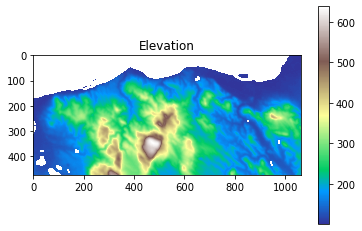

Name: elevation Limits: (100.67122, 638.9841)
Mean: 219.7329864501953 Standard deviation: 95.92752838134766


In [3]:
show_grid(elevation.grid, nodata=elevation.nodata, name='Elevation', cmap='terrain')
elevation.show_info()

### Importing the landslide sample areas  
**LandslideMask** objects store the data for the mask. The mask is used to separate the landslide and the non-landslide areas. The splits for the cross-validation are also computed here. *The cross-validation will be explained later in this notebook.*  
- **name** : The name of the LandslideMask. Eg. *'scarps'*
- **path** : Path to the raster grid of the layer. The same conditions apply as for the VRasters. Eg. *'./data/landslide_layer.sdat'*
- **ls_marker** : The value marking the landslide pixels in the mask layer. Eg. *1*  
- **nls_marker** : The value marking the landslide pixels in the mask layer. Eg. *0*    
- **fold_count** : The number of folds for the cross-validation. Eg. *5*  

In [3]:
scarps = LandslideMask(name='scarps',
                       path='./data/scarps.sdat',
                       ls_marker=1,
                       fold_count=5)

Let's plot the mask. Non-landslide areas are blue, nodata is white, the rest are the landslide pixels. 

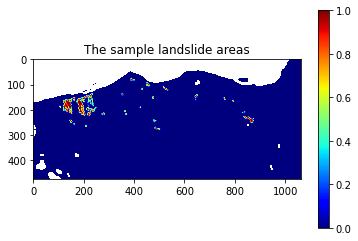

In [5]:
show_grid(scarps.grid, nodata=scarps.nodata, name='The sample landslide areas', cmap='jet')

## Running the analysis
The **frequency ratio analysis** is performed on a list of **VRasters** and on a **LandslideMask**.  

You have to create an **FRAnalysis** object from the rasters and the mask to perform the analysis. This object will store all the data produced during the analysis.  

- **ls_mask** : The LandslideMask for the analysis
- **var_list** : The list of the VRasters to analyze

In [4]:
fra = FRAnalysis(ls_mask=scarps,
                 var_list=[slope,
                           geology,
                           elevation]
                 )

The **frequency ratios** and the **reclassified frequency ratio grids** are computed on the creation of the **FRAnalysis** object. The statistics are stored in the **fr_stats_full** property of the object. The reclassified grids are stored in the **rc_folds** property.  
Let's check the statistics for the slope layer.

In [29]:
fra.fr_stats_full['slope'][0]

,min,max,LS_density,NLS_density,frequency_ratio
0,0.000957,1.089073,0.000751,0.152534,0.004921
1,1.089073,2.177188,0.005504,0.113834,0.048352
2,2.177188,3.265303,0.018014,0.107093,0.168204
3,3.265303,4.353418,0.047536,0.104253,0.455964
4,4.353418,5.441534,0.107330,0.101158,1.061018
5,5.441534,6.529649,0.151864,0.094992,1.598696
6,6.529649,7.617764,0.165124,0.080195,2.059023
7,7.617764,8.705880,0.154366,0.062296,2.477949
8,8.705880,9.793995,0.098824,0.048648,2.031424
9,9.793995,10.882111,0.078059,0.036448,2.141670


You can also plot the statistics. Change 'slope' to 'elevation' or 'geology_14' to check the other layers.

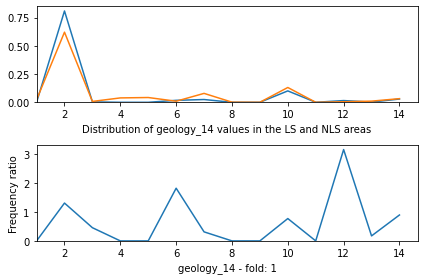

In [30]:
slope_plot = fra.plot_var_fold_fr('geology_14', 0)

### Susceptibility grid
The susceptibility grid is computed by averaging the reclassified grids. You have to call the get_result function of the FRAnalysis to compute the susceptibility grid and some other related data.
Let's 

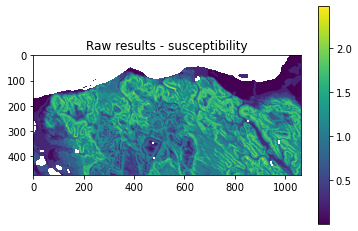

In [6]:
result_percentile_bins = fra.get_result()
show_grid(fra.fresult, nodata=-99999, name="Raw results - susceptibility")

### Cross-validation
Scientists need a way (or more) to test the correctness of their findings. In our case,  we'd like to see if the areas with high landslide susceptibility scores are actually prone to landslides or not. To get the most accurate measurement, we'd have to wait several years and evaluate the results with exhaustive ground checks on the field. In the meantime, we have to work with the already available data to get information about the accuracy of the results.  

**frmod** performs cross-validation for the analysis. The landslide area is randomly split into equal sized parts (or folds) during the cross-validation. One part is turned into a non-landslide cell before performing the analysis. The pixels of this part are called the validation pixels. The result of the analysis is evaluated by checking the number of validation pixels in the different susceptibility categories. This process is then repeated with each split.

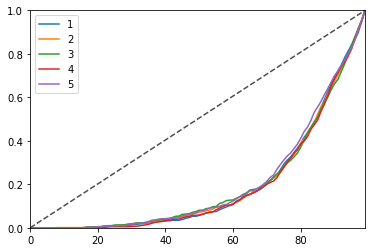

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1f741557748>)

In [19]:
success_rates = fra.get_src()
fra.plot_success_rates()

In [20]:
auc_folds = fra.get_auc()

Auc: 19.23600000000001
Auc: 19.35000000000001
Auc: 19.592592592592595
Auc: 18.92192192192193
Auc: 20.14914914914915
Mean score: 19.44993273273274; Std: 0.4108052127567163


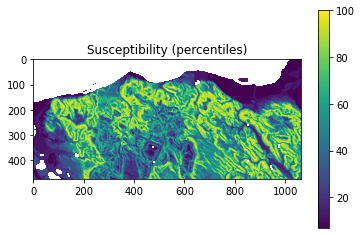

In [21]:
fra.get_percentile_grid(show=True)

In [13]:
from frmod.utils import array2raster

In [14]:
slope.path

'./data/SRTM31_EG_GF_Slope_m.sdat'

In [15]:
array2raster('./data/SRTM31_EG_GF_Slope_m.sdat', './output/grid.sdat', slope.grid)